# Module import

In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import torch.utils.data as data
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'



# Dataset implementation and import


In [2]:
# define directory path
data_dir_path = '/home/yohei/project/cs760/tiny-imagenet-200'

In [3]:
# data formatting (only one time run at the beginning)
def format_val():
    val_dir = data_dir_path + '/val'
    print("Formatting: {}".format(val_dir))
    val_annotations = "{}/val_annotations.txt".format(val_dir)
    val_dict = {}
    with open(val_annotations, 'r') as f:
        for line in f:
            line = line.strip().split()
            assert(len(line) == 6)
            wnind = line[1]
            img_name = line[0]
            boxes = '\t'.join(line[2:])
            if wnind not in val_dict:
                val_dict[wnind] = []
            entries = val_dict[wnind]
            entries.append((img_name, boxes))
    assert(len(val_dict) == 200)
    for wnind, entries in val_dict.items():
        val_wnind_dir = "{}/{}".format(val_dir, wnind)
        val_images_dir = "{}/images".format(val_dir)
        val_wnind_images_dir = "{}/images".format(val_wnind_dir)
        os.mkdir(val_wnind_dir)
        os.mkdir(val_wnind_images_dir)
        wnind_boxes = "{}/{}_boxes.txt".format(val_wnind_dir, wnind)
        f = open(wnind_boxes, "w")
        for img_name, box in entries:
            source = "{}/{}".format(val_images_dir, img_name)
            dst = "{}/{}".format(val_wnind_images_dir, img_name)
            os.system("cp {} {}".format(source, dst))
            f.write(img_name+'\\'+box+'\\'+'n')
        f.close()
    # os.system("rm -rf %s" % val_images_dir)
    #print("Cleaning up: %s" % val_images_dir)
    print("Formatting val done")

In [4]:
# create dataset object
train_dataset = ImageFolder(data_dir_path + '/train', transform=ToTensor())

In [5]:
# Texting label (only one time run at the beginning)
d = {}

f = open(data_dir_path+'/words.txt','r') 
while(1):
    try:
        key, val = f.readline().split("\t")
        d[key] = val[:-1]
    except Exception:
        break

print(len(d))

aa = train_dataset.classes
for i in range(len(aa)):
    train_dataset.classes[i] = d[aa[i]]

82115


In [6]:
# Check some pictures

In [7]:
def show_example(img, label):
    print('Label: ', train_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  stopwatch, stop watch (155)


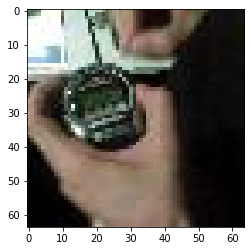

In [8]:
show_example(*train_dataset[77999])

# Training and validation data

In [9]:
random_seed = 42
torch.manual_seed(random_seed);

val_size = 10000
train_size = len(train_dataset) - val_size

train_ds, val_ds = random_split(train_dataset, [train_size, val_size])
len(train_ds), len(val_ds)


(90000, 10000)

In [10]:
batch_size = 16

In [11]:
# 念の為保存しとく↓
# train_dataloader = data.DataLoader(
#     train_dataset, batch_size=16, shuffle=True,
#     num_workers=2, drop_last=True
# )

len(train_dataset.classes)

200

In [12]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)
# なぜ２倍？？

In [13]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

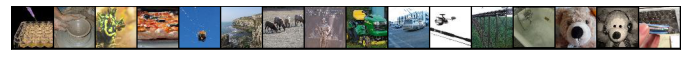

In [14]:
show_batch(train_dl)

# Define the model

In [15]:
def apply_kernel(image, kernel):
    ri, ci = image.shape       # image dimensions
    rk, ck = kernel.shape      # kernel dimensions
    ro, co = ri-rk+1, ci-ck+1  # output dimensions
    output = torch.zeros([ro, co])
    for i in range(ro): 
        for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk,j:j+ck] * kernel)
    return output



In [16]:
sample_image = torch.tensor([
    [3, 3, 2, 1, 0], 
    [0, 0, 1, 3, 1], 
    [3, 1, 2, 2, 3], 
    [2, 0, 0, 2, 2], 
    [2, 0, 0, 0, 1]
], dtype=torch.float32)

sample_kernel = torch.tensor([
    [0, 1, 2], 
    [2, 2, 0], 
    [0, 1, 2]
], dtype=torch.float32)

apply_kernel(sample_image, sample_kernel)

tensor([[12., 12., 17.],
        [10., 17., 19.],
        [ 9.,  6., 14.]])

In [17]:
import torch.nn as nn
import torch.nn.functional as F

In [18]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
    nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2), # output: 64 x 32 x 32

#     nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#     nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
#     nn.MaxPool2d(2, 2), # output: 128 x 16 x 16

#     nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
#     nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
#     nn.MaxPool2d(2, 2), # output: 256 x 8 x 8
    
#     nn.Flatten(), # 16 x 16384
#     nn.Linear(16384, 1024),
#     nn.Linear(1024, 512),
#     nn.Linear(512, 10),
    

)

In [51]:
for images, labels in train_dl:
    print('label:', labels)
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break
    
# out = nn.Flatten()

print(len(out))

label: tensor([196, 176, 122, 131,  52,  49, 180,  51, 120, 102,   5, 137,  90, 105,
         56, 116], device='cuda:0')
images.shape: torch.Size([16, 3, 64, 64])


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [20]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [21]:
class TinyImagenetCnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            # in: 3 x 64 x 64
            
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 32 x 32

#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2), # output: 128 x 16 x 16

#             nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2), # output: 256 x 8 x 8
 
            nn.Flatten(),  # 16 x 16384
            nn.Linear(65536, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 200) # 2番目のargs = # of classes
        )
        
    def forward(self, xb):
        return self.network(xb)

In [22]:
model = TinyImagenetCnnModel()
model

TinyImagenetCnnModel(
  (network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=65536, out_features=1024, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=200, bias=True)
  )
)

In [23]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([16, 3, 64, 64])
out.shape: torch.Size([16, 200])
out[0]: tensor([-3.2108e-03,  9.7152e-03,  3.7845e-02,  1.7623e-02,  2.0726e-02,
        -5.9874e-02, -5.0506e-02,  5.1898e-02,  1.3335e-02, -9.1791e-03,
        -3.7549e-02, -3.2174e-02,  1.0870e-02,  2.7330e-03,  2.6463e-02,
        -1.5708e-02, -5.8099e-03, -2.8913e-02,  3.9842e-02, -7.6406e-03,
         9.0155e-03,  1.5678e-02, -1.4526e-02, -4.1930e-02,  2.7639e-03,
         2.7506e-02,  2.1897e-02, -2.8295e-02, -9.4567e-03,  1.7723e-02,
         6.5376e-03, -8.5977e-03, -3.2585e-04,  1.2119e-02, -3.2867e-02,
        -1.9076e-02,  7.9750e-03, -3.2852e-02, -2.1250e-03,  5.2933e-02,
        -3.8686e-03, -1.0939e-02, -4.4806e-03, -1.2636e-02, -2.7714e-03,
        -3.4728e-02, -2.1980e-02, -1.8998e-02,  8.6201e-03,  3.4115e-02,
        -4.4110e-02, -1.2377e-02,  2.0267e-02,  3.2233e-02,  2.9516e-02,
         2.7967e-03,  2.4415e-02,  4.1538e-03,  5.6089e-02,  4.4946e-03,
        -3.6155e-02,  1.6299e-02, -2.8123

In [24]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [25]:
device = get_default_device()
# device = torch.device('cpu')
device 

device(type='cuda')

In [26]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

# Training the model

In [27]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [28]:
model = to_device(TinyImagenetCnnModel(), device)

In [29]:
evaluate(model, val_dl)

{'val_loss': 5.298436164855957, 'val_acc': 0.006000000052154064}

In [30]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [31]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 5.3001, val_loss: 5.3001, val_acc: 0.0037
Epoch [1], train_loss: 5.2996, val_loss: 5.3009, val_acc: 0.0034
Epoch [2], train_loss: 5.2996, val_loss: 5.3012, val_acc: 0.0031
Epoch [3], train_loss: 5.2996, val_loss: 5.3008, val_acc: 0.0034
Epoch [4], train_loss: 5.2996, val_loss: 5.3009, val_acc: 0.0033
Epoch [5], train_loss: 5.2996, val_loss: 5.3006, val_acc: 0.0034
Epoch [6], train_loss: 5.2996, val_loss: 5.3009, val_acc: 0.0041
Epoch [7], train_loss: 5.2996, val_loss: 5.3008, val_acc: 0.0033
Epoch [8], train_loss: 5.2996, val_loss: 5.3009, val_acc: 0.0047
Epoch [9], train_loss: 5.2996, val_loss: 5.3011, val_acc: 0.0042


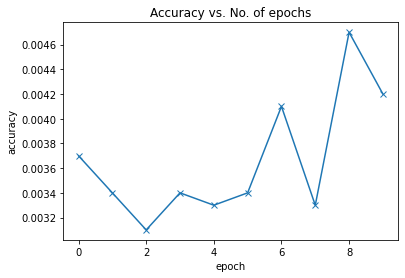

In [32]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');


plot_accuracies(history)



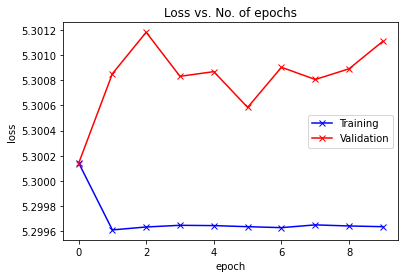

In [33]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    
plot_losses(history)


# Testing with indiv images

In [35]:
test_dataset = ImageFolder(data_dir_path+'/test', transform=ToTensor())

In [42]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_dataset.classes[preds[0].item()]


0
Label: goldfish, Carassius auratus , Predicted: gondola


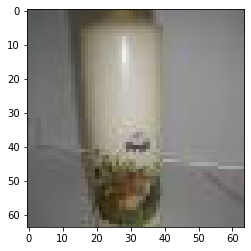

In [49]:
img, label = test_dataset[0]
print(label)
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: goldfish, Carassius auratus , Predicted: gondola


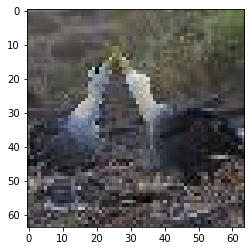

In [47]:
img, label = test_dataset[110]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: goldfish, Carassius auratus , Predicted: gondola


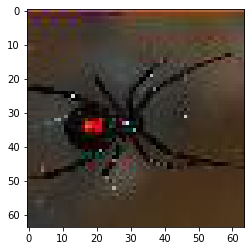

In [50]:
img, label = test_dataset[5300]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_dataset.classes[label], ', Predicted:', predict_image(img, model))

In [52]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 5.297099590301514, 'val_acc': 0.0}